In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import os
import time
import wandb
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
# import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path, PurePath
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
# from warmup_scheduler import GradualWarmupScheduler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, LearningRateMonitor
from torchmetrics.wrappers import ClasswiseWrapper
from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelAccuracy, MultilabelPrecision, MultilabelRecall, MultilabelF1Score

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 1.0.8
torch version 2.3.1


In [4]:
wandb.login(key=os.getenv('wandb_api_key'))

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Asus\.netrc


True

In [5]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [6]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Config

In [7]:
# TODO: maybe use condition and level for classes
classes = ['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'] + ['H'] # add healthy class

# classes = ['SCS', 'RNFN', 'LNFN'] + ['H'] # add healthy class

# classes = ['LSS', 'RSS'] + ['H'] # add healthy class

# classes = ['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
#        'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
#        'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
#        'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
#        'RSSL4L5', 'LSSL5S1', 'RSSL5S1'] + ['H']

num_classes = len(classes)
class2id = {b: i for i, b in enumerate(classes)}

In [8]:
train_dir = Path('E:\data\RSNA2024')

class CFG:

    project = 'rsna-2'
    comment = '128neck'

    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 

    image_size = 256
    bottleneck_dim = 128
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    PNG_DIR = ROOT_FOLDER / f'pngs_{image_size}'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'

    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = RESULTS_DIR / 'ckpt'

    classes = classes

    split_fraction = 0.95

    MIXUP = False

    ### training
    BATCH_SIZE = 32
    
    ### Optimizer
    N_EPOCHS = 10
    USE_SCHD = False
    WARM_EPOCHS = 3
    COS_EPOCHS = N_EPOCHS - WARM_EPOCHS

    # LEARNING_RATE = 5*1e-5 # best
    LEARNING_RATE = 5e-5
    
    weight_decay = 1e-6 # for adamw

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ### split train and validation sets
    num_workers = 16

    random_seed = 42

CFG.N_LABELS = len(CFG.classes)

seed_torch(seed = CFG.random_seed)

In [9]:
CFG.N_LABELS 

6

### Load data

In [10]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)
coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

train_df.shape, train_desc_df.shape, coords_df.shape, files_df.shape

((1975, 26), (6294, 3), (48692, 18), (147218, 20))

In [11]:
train_df.sample(5)

,study_id,SCSL1L2,SCSL2L3,SCSL3L4,SCSL4L5,SCSL5S1,LNFNL1L2,LNFNL2L3,LNFNL3L4,LNFNL4L5,...,LSSL1L2,LSSL2L3,LSSL3L4,LSSL4L5,LSSL5S1,RSSL1L2,RSSL2L3,RSSL3L4,RSSL4L5,RSSL5S1
1825,3956571539,N,N,N,N,N,N,N,N,M,...,N,N,N,M,N,N,N,N,N,M
1735,3768387090,N,N,N,M,N,N,N,N,N,...,N,N,N,S,N,N,N,N,N,N
678,1504031267,N,N,N,N,N,N,N,M,M,...,N,M,M,N,N,N,N,N,N,N
351,783154228,N,M,S,N,N,M,S,M,S,...,N,M,M,N,N,N,M,M,M,M
1791,3884015124,M,N,M,N,N,N,N,N,M,...,M,N,N,S,S,M,N,M,M,M


In [12]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
9389,838134337,1345841225,8,RNFN,L1L2,299.627093,141.857522,838134337_1345841225,838134337_1345841225_8,RNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\838134337_1345841225...,HFS,0.585209,0.277065,0.350000
34671,3068697362,598012396,5,LNFN,L5S1,132.562118,195.910387,3068697362_598012396,3068697362_598012396_5,LNFNL5S1,Sagittal T1,256,256,E:\data\RSNA2024\pngs_256\3068697362_598012396...,HFS,0.517821,0.765275,0.222222


In [13]:
coords_df.condition.unique()

array(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'], dtype=object)

In [14]:
coords_df.cl.unique()

array(['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
       'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
       'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
       'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
       'RSSL4L5', 'LSSL5S1', 'RSSL5S1'], dtype=object)

In [15]:
# coords_df.groupby(['study_id','series_id']).instance.count()

In [16]:
train_desc_df.sample(5)

,study_id,series_id,series_description
3465,2403128572,1121608562,Sagittal T2/STIR
2413,1671291853,1440089134,Axial T2
5109,3480977444,2937779262,Axial T2
3727,2568819355,3366910731,Axial T2
5996,4095029738,3276164246,Sagittal T2/STIR


In [17]:
files_df.sample(3)

,study_id,series_id,image,proj,instancenumber,rows,columns,slicethickness,spacingbetweenslices,patientposition,seriesdescription,ss_id,instance_id,filename,series_description,healthy,inst_min,inst_max,inst,inst_perc
14665,3870889542,1025648500,5,-16,5,512,512,4.0,5.0,FFS,T2,3870889542_1025648500,3870889542_1025648500_5,E:\data\RSNA2024\pngs_256\3870889542_102564850...,Sagittal T2/STIR,True,1,16,4,0.250000
13125,3895795003,4117993048,21,-437,21,320,320,4.0,4.4,HFS,T2,3895795003_4117993048,3895795003_4117993048_21,E:\data\RSNA2024\pngs_256\3895795003_411799304...,Axial T2,False,1,24,20,0.833333
26491,3507232306,68802292,11,17,11,512,512,3.0,4.0,HFS,T1,3507232306_68802292,3507232306_68802292_11,E:\data\RSNA2024\pngs_256\3507232306_68802292_...,Sagittal T1,True,1,15,10,0.666667


In [18]:
files_df.shape

(147218, 20)

In [19]:
# labels, potive imgs, total imgs
coords_df.instance_id.nunique(), coords_df.ss_id.nunique(), files_df.shape[0]

(24546, 6291, 147218)

In [20]:
coords_df.sample(3)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
34000,3010856283,3908286977,9,SCS,L3L4,167.832287,148.588357,3010856283_3908286977,3010856283_3908286977_9,SCSL3L4,Sagittal T2/STIR,320,320,E:\data\RSNA2024\pngs_256\3010856283_390828697...,HFS,0.524476,0.464339,0.470588
35159,3127048494,4135498856,10,LSS,L3L4,274.673837,262.827798,3127048494_4135498856,3127048494_4135498856_10,LSSL3L4,Axial T2,512,512,E:\data\RSNA2024\pngs_256\3127048494_413549885...,HFS,0.536472,0.513336,0.450000
35173,3128795155,483456514,6,RNFN,L3L4,224.246055,234.605452,3128795155_483456514,3128795155_483456514_6,RNFNL3L4,Sagittal T1,448,448,E:\data\RSNA2024\pngs_256\3128795155_483456514...,HFS,0.500549,0.523673,0.238095


In [21]:
files_df.shape, coords_df.shape

((147218, 20), (48692, 18))

In [22]:
coords_df.instance_id.nunique(), coords_df.filename.nunique()

(24546, 24546)

In [23]:
# conditions per file
grp = coords_df.groupby('instance_id').condition
grp.count().min(), grp.count().max(), grp.count().mean()

(1, 10, 1.983704065835574)

In [24]:
inst_id = '2509953825_3594374345_13'

coords_df[coords_df['instance_id'] == inst_id]

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
28080,2509953825,3594374345,13,LNFN,L1L2,261.574913,169.923345,2509953825_3594374345,2509953825_3594374345_13,LNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.510889,0.331882,0.666667
28081,2509953825,3594374345,13,LNFN,L2L3,255.331010,211.846690,2509953825_3594374345,2509953825_3594374345_13,LNFNL2L3,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.498693,0.413763,0.666667
28082,2509953825,3594374345,13,LNFN,L3L4,252.655052,252.878049,2509953825_3594374345,2509953825_3594374345_13,LNFNL3L4,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.493467,0.493902,0.666667
28083,2509953825,3594374345,13,LNFN,L4L5,258.006969,294.801394,2509953825_3594374345,2509953825_3594374345_13,LNFNL4L5,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.503920,0.575784,0.666667
28084,2509953825,3594374345,13,LNFN,L5S1,279.414634,333.156794,2509953825_3594374345,2509953825_3594374345_13,LNFNL5S1,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.545732,0.650697,0.666667


In [25]:
coords_df[coords_df['instance_id'] == inst_id].cl.to_list()

['LNFNL1L2', 'LNFNL2L3', 'LNFNL3L4', 'LNFNL4L5', 'LNFNL5S1']

In [26]:
# list(coords_df.filename.unique())

### Dataset

In [27]:
from dataset import rsna_dataset

In [28]:
selection = files_df[files_df['healthy'] == True]
selection.shape

(122672, 20)

In [29]:
dset = rsna_dataset(selection, coords_df, CFG)

print(dset.__len__())

img, label, = dset.__getitem__(2)
print(img.shape, label.shape)
print(img.dtype, label.dtype)

122672
(3, 256, 256) torch.Size([6])
float32 torch.float32


In [30]:
label

tensor([0., 0., 0., 0., 0., 1.])

In [31]:
selection = files_df[files_df['healthy'] == False]
selection.shape

(24546, 20)

In [105]:
dset = rsna_dataset(selection, coords_df, CFG)

print(dset.__len__())

img, label, = dset.__getitem__(8)
print(img.shape, label.shape)
print(img.dtype, label.dtype)
label

24546
(3, 256, 256) torch.Size([6])
float32 torch.float32


tensor([0., 0., 0., 1., 1., 0.])

In [34]:
img.mean(), img.std(), img.min(), img.max()

(23.364578, 27.800598, 0.0, 243.0)

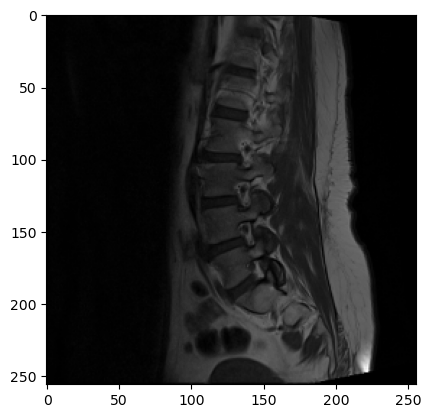

In [35]:
plt.imshow(img[0], cmap='gray')

### Datamodule

In [36]:
from dataset import rsna_dataset

In [37]:
class rsna_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, coords_df, cfg=CFG, train_tfs=None, val_tfs=None):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        self.coords_df = coords_df
        
        self.train_bs = cfg.BATCH_SIZE
        self.val_bs = cfg.BATCH_SIZE

        self.train_tfs = train_tfs
        self.val_tfs = val_tfs

        self.cfg = cfg
        
        self.num_workers = cfg.num_workers
        
    def train_dataloader(self):
        train_ds = rsna_dataset(self.train_df, self.coords_df, self.cfg, tfs=self.train_tfs, mode='train')
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = rsna_dataset(self.val_df, self.coords_df, self.cfg, tfs=self.val_tfs, mode='val')
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=2,
        )
        
        return val_loader

In [38]:


t_df = selection[:-100]
# t_df = pd.concat([meta_df[:-100], ul_df[:-100]], ignore_index=True)
v_df = selection[-100:]

CFG2 = CFG()
# CFG2 = copy.deepcopy(CFG)
CFG2.BATCH_SIZE = 16
CFG2.num_workers = 2

dm = rsna_datamodule(t_df, v_df, coords_df, cfg=CFG2)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 6]),
 torch.float32,
 torch.float32)

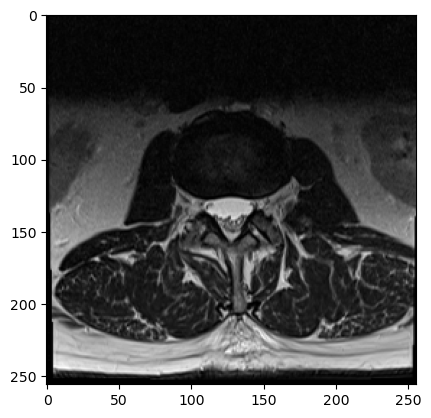

In [39]:
plt.imshow(x[10][0], cmap='gray')

#### Check Transforms

In [40]:
image_size = CFG.image_size

img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

train_tfs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    A.CoarseDropout(max_height=int(image_size * 0.2), max_width=int(image_size * 0.2), max_holes=4, p=0.7),
    A.Normalize(mean=img_mean, std=img_std)
])

val_tfs = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=img_mean, std=img_std)
])

In [41]:
dm = rsna_datamodule(t_df, v_df, coords_df, cfg=CFG2, train_tfs=train_tfs, val_tfs=val_tfs)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 6]),
 torch.float32,
 torch.float32)

In [42]:
y[0]

tensor([0., 0., 1., 0., 0., 0.])

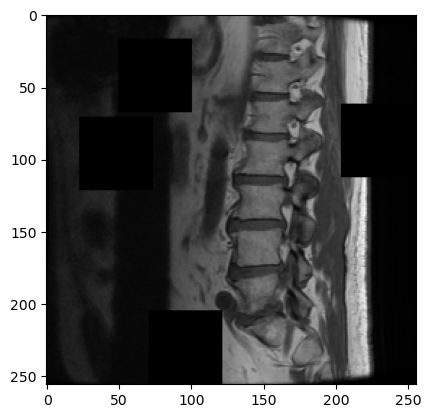

In [43]:
plt.imshow(x[2][0], cmap='gray')

In [44]:
del dm

### Loss function

In [45]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [46]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Model

In [47]:
backbone = 'eca_nfnet_l1'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=dset.num_classes,
    # out_indices=out_indices,
    )

model.feature_info.channels(), np.sum(model.feature_info.channels())

([64, 256, 512, 1536, 3072], 5440)

In [48]:
data_config = timm.data.resolve_model_data_config(model)

In [49]:
data_config

{'input_size': (3, 256, 256),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [50]:
def mixup(data, targets, alpha, device):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)]).to(device)
    data = data * lam + data2 * (1 - lam)
    
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

    # data += data2
    # targets += targets2
    # return data, targets.clip(max=1)

In [51]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg

        self.dev = cfg.device
        
        out_indices = (3, 4)

        self.bottleneck_dim = cfg.bottleneck_dim

        self.criterion = FocalLossBCE()

        wrapped_acc = ClasswiseWrapper(MultilabelAccuracy(num_labels=self.cfg.N_LABELS, average='none'), labels=classes, prefix='multiacc/')
        wrapped_f1 = ClasswiseWrapper(MultilabelF1Score(num_labels=self.cfg.N_LABELS, average='none'), labels=classes, prefix='multif1/')
        
        metrics = MetricCollection({
            # 'macc': MultilabelAccuracy(num_labels=self.cfg.N_LABELS),
            'none_acc': wrapped_acc,
            'mpr': MultilabelPrecision(num_labels=self.cfg.N_LABELS),
            'mrec': MultilabelRecall(num_labels=self.cfg.N_LABELS),
            'f1': MultilabelF1Score(num_labels=self.cfg.N_LABELS),
            'none_f1': wrapped_f1,
        })

        self.train_metrics = metrics.clone(prefix='train/')
        self.valid_metrics = metrics.clone(prefix='val/')
        
        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.bottleneck = torch.nn.Linear(self.mid_features, self.bottleneck_dim)
        self.bottleneck_bn = torch.nn.BatchNorm1d(self.bottleneck_dim)
        self.head = torch.nn.Linear(self.bottleneck_dim, self.cfg.N_LABELS)

    def pre_forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.bottleneck(x)
        x = self.bottleneck_bn(x)

        return x
    
    def forward(self, x):
        x = self.pre_forward(x)

        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LEARNING_RATE, weight_decay=CFG.weight_decay)
        
        if self.cfg.USE_SCHD:
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.cfg.COS_EPOCHS)
            scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=self.cfg.WARM_EPOCHS, after_scheduler=scheduler_cosine)

            return [optimizer], [scheduler_warmup]
        else:
            # LRscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
            
            # return [optimizer], [LRscheduler]
            return optimizer

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch

        if self.cfg.MIXUP and mode == 'train':
            x, y = mixup(x, y, 0.5, self.cfg.device)
        
        preds = self(x)
        
        loss = self.criterion(preds, y)
        
        if mode == 'train':
            output = self.train_metrics(preds, y)
            self.log_dict(output)
        else:
            self.valid_metrics.update(preds, y)

        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='val')
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        output = self.valid_metrics.compute()
        self.log_dict(output)

        self.valid_metrics.reset()

In [52]:
model = GeMModel(CFG)

eca_nfnet_l0


In [53]:
foo = model(x)

In [54]:
x.shape, foo.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 6]))

### Split

In [55]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [56]:
train_cols = ['filename', 'instance_id', 'series_description', 'condition']

In [57]:
healthy_df = files_df[files_df.healthy == True]
healthy_df['condition'] = 'H'

healthy_df.shape

C:\Users\Asus\AppData\Local\Temp\ipykernel_38360\3018889158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_df['condition'] = 'H'


(122672, 21)

In [58]:
healthy_df = healthy_df.sample(frac=.3)
healthy_df.shape

(36802, 21)

In [59]:
healthy_df.head(2)

,study_id,series_id,image,proj,instancenumber,rows,columns,slicethickness,spacingbetweenslices,patientposition,...,ss_id,instance_id,filename,series_description,healthy,inst_min,inst_max,inst,inst_perc,condition
12169,3922074884,3753272699,18,2,18,512,512,4.0,4.3,FFS,...,3922074884_3753272699,3922074884_3753272699_18,E:\data\RSNA2024\pngs_256\3922074884_375327269...,Sagittal T1,True,1,19,17,0.894737,H
114605,951328272,4072685621,6,-380,6,320,320,4.0,4.4,HFS,...,951328272_4072685621,951328272_4072685621_6,E:\data\RSNA2024\pngs_256\951328272_4072685621...,Axial T2,True,1,50,5,0.100000,H


In [60]:
coords_df.head(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
0,4003253,702807833,8,SCS,L1L2,322.831858,227.964602,4003253_702807833,4003253_702807833_8,SCSL1L2,Sagittal T2/STIR,640,640,E:\data\RSNA2024\pngs_256\4003253_702807833_8.png,HFS,0.504425,0.356195,0.466667
1,4003253,702807833,8,SCS,L2L3,320.571429,295.714286,4003253_702807833,4003253_702807833_8,SCSL2L3,Sagittal T2/STIR,640,640,E:\data\RSNA2024\pngs_256\4003253_702807833_8.png,HFS,0.500893,0.462054,0.466667


In [61]:
coords_df.loc[:, train_cols].sample(5)

,filename,instance_id,series_description,condition
33685,E:\data\RSNA2024\pngs_256\2980524900_121187883...,2980524900_1211878837_11,Sagittal T1,RNFN
12100,E:\data\RSNA2024\pngs_256\1086363712_141107934...,1086363712_1411079343_18,Axial T2,LSS
40832,E:\data\RSNA2024\pngs_256\3582253639_121978340...,3582253639_1219783402_13,Sagittal T1,RNFN
36607,E:\data\RSNA2024\pngs_256\3234424112_385365277...,3234424112_3853652770_10,Sagittal T2/STIR,SCS
7729,E:\data\RSNA2024\pngs_256\691922299_4176012336...,691922299_4176012336_8,Axial T2,LSS


In [62]:
healthy_df.loc[:, train_cols].sample(5)

,filename,instance_id,series_description,condition
133072,E:\data\RSNA2024\pngs_256\391103067_3707725327...,391103067_3707725327_10,Sagittal T1,H
78323,E:\data\RSNA2024\pngs_256\2028028580_308447317...,2028028580_3084473175_32,Axial T2,H
103032,E:\data\RSNA2024\pngs_256\1292979992_335942806...,1292979992_3359428067_16,Sagittal T2/STIR,H
36109,E:\data\RSNA2024\pngs_256\3239069834_253359462...,3239069834_2533594621_30,Axial T2,H
46199,E:\data\RSNA2024\pngs_256\2945946028_161270704...,2945946028_1612707049_1,Sagittal T1,H


In [63]:
train_df = pd.concat([coords_df.loc[:, train_cols], healthy_df.loc[:, train_cols]], ignore_index=True)
train_df.shape

(85494, 4)

In [64]:
train_df.filename.nunique()

61348

In [65]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-CFG.split_fraction, random_state=CFG.random_seed)
train_idx, val_idx = next(sss.split(train_df.filename, train_df.condition))

t_df = train_df.iloc[train_idx]
v_df = train_df.iloc[val_idx]

t_df.shape, v_df.shape

((81219, 4), (4275, 4))

In [66]:
bool(set(t_df.instance_id.tolist()) & set(v_df.instance_id.tolist()))

True

In [67]:
intersection = list(set(t_df.instance_id.tolist()) & set(v_df.instance_id.tolist()))
len(intersection)

1764

In [68]:
intersection[0]

'706497544_1649968039_15'

In [69]:
coords_df[coords_df.instance_id == '3922074884_1280331258_30']

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
44588,3922074884,1280331258,30,LSS,L1L2,272.459644,303.978112,3922074884_1280331258,3922074884_1280331258_30,LSSL1L2,Axial T2,512,512,E:\data\RSNA2024\pngs_256\3922074884_128033125...,FFS,0.532148,0.593707,0.763158
44589,3922074884,1280331258,30,RSS,L1L2,215.735714,294.400000,3922074884_1280331258,3922074884_1280331258_30,RSSL1L2,Axial T2,512,512,E:\data\RSNA2024\pngs_256\3922074884_128033125...,FFS,0.421359,0.575000,0.763158


In [70]:
v_df[v_df.instance_id == '3922074884_1280331258_30']

,filename,instance_id,series_description,condition


#### Filter classes

In [71]:
CFG.classes

['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS', 'H']

In [72]:
t_df[t_df['condition'].isin(CFG.classes)].shape, v_df[v_df['condition'].isin(CFG.classes)].shape

((81219, 4), (4275, 4))

In [73]:
t_df = t_df[t_df['condition'].isin(CFG.classes)]
v_df = v_df[v_df['condition'].isin(CFG.classes)]

In [74]:
t_df.shape, v_df.shape

((81219, 4), (4275, 4))

In [75]:
69576/128, 3662/128

(543.5625, 28.609375)

### Train

In [76]:
CFG.BATCH_SIZE, CFG.device

(32, 'cuda')

In [77]:
dm = rsna_datamodule(t_df, v_df, coords_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)
len(dm.train_dataloader()), len(dm.val_dataloader())

(1842, 131)

In [78]:
run_name = f'{CFG.model_name} {CFG.LEARNING_RATE} {CFG.N_EPOCHS} eps {CFG.comment}'
run_name

'eca_nfnet_l0 5e-05 10 eps 128neck'

In [79]:
wandb_logger = WandbLogger(
    name=run_name,
    project=CFG.project,
    job_type='train',
    save_dir=CFG.RESULTS_DIR,
    # config=cfg,
)

loss_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/loss',
    auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    filename='ep_{epoch:02d}_loss_{val/loss:.5f}',
    save_top_k=2,
    mode='min',
)

# acc_ckpt = pl.callbacks.ModelCheckpoint(
#     monitor='val/acc',
#     auto_insert_metric_name=False,
#     dirpath=CFG.CKPT_DIR / run_name,
#     filename='ep_{epoch:02d}_acc_{val/acc:.5f}',
#     save_top_k=2,
#     mode='max',
# )

lr_monitor = LearningRateMonitor(logging_interval='step')

In [80]:
trainer = pl.Trainer(
    max_epochs=CFG.N_EPOCHS,
    deterministic=True,
    accelerator=CFG.device,
    default_root_dir=CFG.RESULTS_DIR,
    gradient_clip_val=0.5, 
    # gradient_clip_algorithm="value",
    logger=wandb_logger,
    callbacks=[loss_ckpt, lr_monitor],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [81]:
model = GeMModel(CFG)

eca_nfnet_l0


#### Fit

In [82]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory E:\data\RSNA2024\results\ckpt\eca_nfnet_l0 5e-05 10 eps 128neck exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | FocalLossBCE     | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | valid_metrics | MetricCollection | 0      | train
3 | backbone      | FeatureListNet   | 21.8 M | train
4 | global_pools  | ModuleList       | 2      | train
5 | neck          | BatchNorm1d      | 7.7 K  | train
6 | bottleneck    | Linear           | 491 K  | train
7 | bottleneck_bn | BatchNorm1d      | 256    | train
8 | head          | Linear           | 774    | train
-----------------------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

Training: |                                                                               | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [83]:
# np.array([0.0625, 0.9375, 0.8125, 0.0000, 1.0000, 1.0000, 0.0938, 0.8125, 0.7500,
#         0.8750, 0.2500, 0.0625, 0.9688, 0.9062, 0.9688, 0.1875, 1.0000, 0.6562,
#         0.7500, 0.7812, 0.6875, 0.8438, 0.8750, 0.9688, 0.4062, 0.2188]).mean()

In [84]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/f1,▂▂▄▇▅▅▃▄▇▆▂▄▆▆▅▁▇▇█▇▅▇▆▄██▆▄▅▅▆▆▃█▂█▅█▇█
train/loss_epoch,█▄▃▂▂▂▁▁▁▁
train/loss_step,██▆▄▄▄▄▃▂▃▂▃▂▃▁▂▂▂▁▂▃▁▂▂▂▁▂▂▃▂▂▁▂▁▂▁▁▁▁▁
train/mpr,▁▂▄▆▅▄▃▅▇▆▂▄▇▅▆▁▇▇█▆▅▇▆▄▇▇█▄▅▅▇▆▃▇▂█▅█▇█
train/mrec,█▅▇█▅▅▄▃▆▆▂▄▆▇▅▁▇▇▇█▄▆▇▆██▅▄▄▆▆▆▃█▃▇▄█▆▇
train/multiacc/H,▁▂▂▆▆▅▃▅▅▁▆▂▆▂▇▅▆▆█▇▆▇▆▃▇▇▃▃▅▇▆█▇█▇████▅
train/multiacc/LNFN,▁▃███▇▇▇██▇██▆█████▇▇█▇▇██▇███████████▇█
train/multiacc/LSS,▃▅▅▄▅▅▆▁▅▅▅▇▅▄█▄▅▆▇▆▇▆▅▅▆▆▇▅▃▅▅▇▅▆▄▇▅▆▅█
train/multiacc/RNFN,▁▃▃█▇▇████▇▇▇▇███▇██▇█▇███▇█████████████


### Predict

In [85]:
x, y = next(iter(dm.train_dataloader()))

In [86]:
foo = model(x)
# foo = model(x.to(CFG.device)).detach().cpu()
foo.shape

torch.Size([32, 6])

In [87]:
foo[0]

tensor([-7.7421, -7.6577, -6.6064, -4.5188, -5.3812,  4.6799],
       grad_fn=<SelectBackward0>)

In [88]:
foo[0].sigmoid()

tensor([4.3395e-04, 4.7215e-04, 1.3499e-03, 1.0785e-02, 4.5812e-03, 9.9081e-01],
       grad_fn=<SigmoidBackward0>)

In [89]:
macc = tm.classification.MultilabelAccuracy(num_labels=26)
mapp = tm.classification.MultilabelPrecision(num_labels=26)
marr = tm.classification.MultilabelRecall(num_labels=26)
maff = tm.classification.MultilabelF1Score(num_labels=26)

In [90]:
macc(foo, y), mapp(foo, y), marr(foo, y), maff(foo, y)

ValueError: Expected both `target.shape[1]` and `preds.shape[1]` to be equal to the number of labels but got 6 and expected 26

In [ ]:
((foo.sigmoid() > 0.5) == y).sum()/16/26

In [ ]:
((foo.sigmoid() > 0.5) != y).sum()

In [ ]:
(1037.3 - 1026)/1026 * 100

In [ ]:
torch.argwhere(y > 0).T

In [ ]:
bar = foo.sigmoid().numpy()
np.argwhere(bar > 0.5).T

In [ ]:
bar[12]

# 

In [ ]:
torch.nn.functional.sigmoid(foo[0])

In [ ]:
# foo.sigmoid().topk(1, dim=-1)